In [1]:
%%HTML 
<script>
    function luc21893_refresh_cell(cell) {
        if( cell.luc21893 ) return;
        cell.luc21893 = true;
        console.debug('New code cell found...' );
        
        var div = document.createElement('DIV');            
        cell.parentNode.insertBefore( div, cell.nextSibling );
        div.style.textAlign = 'right';
        var a = document.createElement('A');
        div.appendChild(a);
        a.href='#'
        a.luc21893 = cell;
        a.setAttribute( 'onclick', "luc21893_toggle(this); return false;" );

        cell.style.visibility='hidden';
        cell.style.position='absolute';
        a.innerHTML = '[show code]';        
                
    }
    function luc21893_refresh() {                
        if( document.querySelector('.code_cell .input') == null ) {            
            // it apeears that I am in a exported html
            // hide this code
            var codeCells = document.querySelectorAll('.jp-InputArea')
            codeCells[0].style.visibility = 'hidden';
            codeCells[0].style.position = 'absolute';                        
            for( var i = 1; i < codeCells.length; i++ ) {
                luc21893_refresh_cell(codeCells[i].parentNode)
            }
            window.onload = luc21893_refresh;
        }                 
        else {
            // it apperas that I am in a jupyter editor
            var codeCells = document.querySelectorAll('.code_cell .input')
            for( var i = 0; i < codeCells.length; i++ ) {
                luc21893_refresh_cell(codeCells[i])
            }            
            window.setTimeout( luc21893_refresh, 1000 )
        }        
    }
    
    function luc21893_toggle(a) {
        if( a.luc21893.style.visibility=='hidden' ) {
            a.luc21893.style.visibility='visible';        
            a.luc21893.style.position='';
            a.innerHTML = '[hide code]';
        }
        else {
            a.luc21893.style.visibility='hidden';        
            a.luc21893.style.position='absolute';
            a.innerHTML = '[show code]';
        }
    }
    
    luc21893_refresh()
</script>

## Etermax - Data Science Exercise Dataset

El dataset en cuestión cuenta de los siguientes campos:  
● user_id: identificador unívoco anonimizado del usuario.  
● install_time: indica la fecha y horario en que se registró la instalación (UTC).  
● platform: plataforma del usuario, puede ser: Android o iOS.  
● country_region: sería el equivalente a provincia.  
● city: ciudad.  
● gender: género del usuario, puede ser: hombre o mujer.  
● min_age_range: cota inferior del rango de edad.  
● max_age_range: cota superior del rango de edad.  
● event_1: cantidad de eventos de un tipo anonimizado.  
● event_2: cantidad de eventos de un tipo anonimizado.  
● event_3: cantidad de eventos de un tipo anonimizado.  
● event_4: cantidad de eventos de un tipo anonimizado.  
● event_5: cantidad de eventos de un tipo anonimizado.  
● target_churn_indicator: Si es 1 significa que no jugó el día siguiente, en cambio, si es 0
significa que jugó.

## Tabla de Contenidos

* [1) Los datos](#losdatos)

* [2) Analisis previo y limpieza](#Analisis)
    
* [3) Analisis exploratorio por variable](#EDA)
    * [3.1)Target: Churn](#Target)
    * [3.2)User ID](#UserID)
    * [3.3)Age](#Age)
    * [3.4)Install time](#InstallTime)
    * [3.5)Platform](#Platform)
    * [3.6)Gender](#Gender)
    * [3.7)Provincia](#Provincia)
    * [3.8)City](#City)
    * [3.9)Traveller](#Traveller)
    * [3.10)Events 1,2,3,4,5](#Events)
    * [3.11)Merge con Clima y análisis temperatura y clima](#Clima)
        
* [4) Modelo de clasificacion](#Modelo)
    * [3.1)Preprocesamiento](#Preprocesamiento)
    * [3.1)Modelo](#Modelo1)
    * [3.1)Evaluacion](#Evaluacion)
    * [3.1)Explicacion Shapley](#Shap)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore")

import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

In [3]:
df = pd.read_csv('data/data_science_exercise_dataset.csv')

### Primera vista:  <a class="anchor" id="losdatos"></a>

In [4]:
df.head()

,user_id,install_time,platform,country_region,city,gender,min_age_range,max_age_range,event_1,event_2,event_3,event_4,event_5,target_churn_indicator
0,2ba6f357,2018-07-04 19:24:24,Android,Santa Cruz,Río Gallegos,male,13,17,1,2,0,1,1,0
1,3cb936c1,2018-06-30 13:41:29,Android,Corrientes,Corrientes,male,13,17,0,7,0,3,0,1
2,17d88bbc,2018-06-30 16:02:30,Android,Cordoba,Villa Carlos Paz,female,18,20,2,1,0,2,2,1
3,7baa10b6,2018-07-02 21:08:33,Android,Buenos Aires,Don Torcuato,female,13,17,5,6,0,2,5,0
4,120d379,2018-07-07 04:18:47,Android,Santiago del Estero,Santiago del Estero,female,13,17,8,12,0,2,3,0


## Análisis previo: nulos, missing y particularidades  <a class="anchor" id="Analisis"></a>

Dataset conformado por 14 features y 20000 observaciones, donde se destacan los siguientes puntos (además de la información recibida).
-	User ID: se encontró que existen usuarios que aparecen más de una vez en el set de datos. Luego de analizar caso por caso, se determinó que no tenía que ver con distintas instalaciones (mismo install_time), sino a que los eventos generados correspondían a distintas localizaciones geográficas. Por ello, a los registros de estos usuarios, decidimos agregarle una marca “traveller”, que se visualizará como una nueva feature, teniendo valor “Si” para ellos y “No”, para los usuarios que tienen eventos solo en una localización geográfica.
-	Install Time: Fecha y horario en la que se registró la instalación. El rango de datos del dataset es del 30-06-2018 al 07-07-2018. Como las observaciones se encuentran en timezone UTC, decidí cambiar la timezone a GMT -3, correspondiente a Argentina, donde ocurren las instalaciones y los eventos realizados por los usuarios.  
o	En base a install time, se crearon distintas columnas que podían ser útiles en el análisis.  
  	Dia de la semana (Lun, Mar, Mie…)  
  	Hora del día (1, 2, 3… 24)  
  	Estacion del año (Invierno, Verano)  
-	Country region: Este campo, referente a la provincia, presentaba distintos labels para las mismas provincias (33 en total, cuando hay 24 provincias), por ejemplo: Chubut province y Chubut, Buenos Aires F.D. y Ciudad Autonoma de Buenos Aires. Se realizó la unificación.
-	City: 772 valores únicos. Lo que puede ser peligroso en términos de análisis teniendo solo 20000 observaciones en el conjunto de datos.
-	Gender: 3 posibilidades: male, female, unknown. Voy a optar por dejarlo así y asumir que unknown es sinónimo de “no binario”. (Podría haber sido tomado como NaN y realizar una asignación).
-	Platform: Sin valores nulos, sin cambios en el análisis preliminar.
-	Min age y max age: decidí cambiar estas variables por una sola que sea el promedio de ambas, para evitar tener dos variables perfectamente correlacionadas y agregar dimensionalidad innecesaria al problema. Una vez realizado, encontré que dos categorías contenían más del 99,99% de los datos, por lo que procedí a dropear los registros con distintos rangos. Sospecha: quedaron incluidos en la muestra por error o error de carga de los usuarios si hubiese sido manual en algún caso.
-	Events 1,2,3,4 y 5: sin valores nulos. A priori lo que se identifica es que tienen diferentes escalas por lo que podría ser una buena práctica normalizar estos datos.
-	Target: sin valores nulos, dos posibilidades: 0, que indica que el usuario siguió jugando al día siguiente y 1, que indica caso de churn, es decir, el usuario no jugó al día siguiente. Distribución: 54% observaciones de churn y 45,9% no churn.

In [5]:
df.describe(include='all')

,user_id,install_time,platform,country_region,city,gender,min_age_range,max_age_range,event_1,event_2,event_3,event_4,event_5,target_churn_indicator
count,20000,20000,20000,19521,19065,20000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000
unique,18533,18207,2,33,772,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,75d198ce,2018-07-01 03:24:22,Android,Buenos Aires,Buenos Aires,female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4,4,19512,6831,2626,10835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,16.145300,18.884050,13.751700,18.80975,0.526850,4.341200,4.452500,0.540700
std,NaN,NaN,NaN,NaN,NaN,NaN,2.420017,1.450452,19.041115,26.93790,1.245695,4.218456,4.506946,0.498353
min,NaN,NaN,NaN,NaN,NaN,NaN,13.000000,13.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,13.000000,17.000000,2.000000,3.00000,0.000000,1.000000,2.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,20.000000,6.000000,9.00000,0.000000,3.000000,3.000000,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,20.000000,18.000000,24.00000,1.000000,6.000000,6.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   user_id                 20000 non-null  object
 1   install_time            20000 non-null  object
 2   platform                20000 non-null  object
 3   country_region          19521 non-null  object
 4   city                    19065 non-null  object
 5   gender                  20000 non-null  object
 6   min_age_range           20000 non-null  int64 
 7   max_age_range           20000 non-null  int64 
 8   event_1                 20000 non-null  int64 
 9   event_2                 20000 non-null  int64 
 10  event_3                 20000 non-null  int64 
 11  event_4                 20000 non-null  int64 
 12  event_5                 20000 non-null  int64 
 13  target_churn_indicator  20000 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 2.1+ MB


##### Cambiar timezone de UTC a GMT-3: 3 horas menos

In [7]:
df['install_time'] = pd.to_datetime(df['install_time']).dt.tz_localize('UTC').dt.tz_convert('America/Argentina/Catamarca')

In [8]:
df['install_time'].head(1)

0   2018-07-04 16:24:24-03:00
Name: install_time, dtype: datetime64[ns, America/Argentina/Catamarca]

##### Data desde el 30 Junio 2018 al 7 de Julio 2018 (UTC), varia unas horas cuando cambiamos a GMT -3

In [9]:
df['install_time'].min()

Timestamp('2018-06-29 21:00:36-0300', tz='America/Argentina/Catamarca')

In [10]:
df['install_time'].max()

Timestamp('2018-07-07 20:59:47-0300', tz='America/Argentina/Catamarca')

##### No hay registros duplicados (todas las features iguales)

In [11]:
df[df.duplicated()==True].shape

(0, 14)

##### Tratemiento de nulls en country_region y city: imputo la moda para esta variable categorica

In [12]:
df = df.fillna(df.mode().iloc[0])

Chequeo que no tengo nulos

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype                                      
---  ------                  --------------  -----                                      
 0   user_id                 20000 non-null  object                                     
 1   install_time            20000 non-null  datetime64[ns, America/Argentina/Catamarca]
 2   platform                20000 non-null  object                                     
 3   country_region          20000 non-null  object                                     
 4   city                    20000 non-null  object                                     
 5   gender                  20000 non-null  object                                     
 6   min_age_range           20000 non-null  int64                                      
 7   max_age_range           20000 non-null  int64                                      
 

## Analisis exploratorio de variables y cruce con Churn <a class="anchor" id="EDA"></a>

### Target: Churn  <a class="anchor" id="Churn"></a> 

Dos posibilidades: 0, que indica que el usuario siguió jugando al día siguiente y 1, que indica caso de churn, es decir, el usuario no jugó al día siguiente. Distribución:

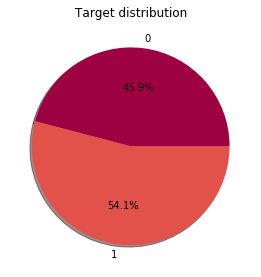

In [14]:
churn = df.groupby('target_churn_indicator').agg('count')
type_labels = churn['user_id'].sort_values().index 
type_counts = churn['user_id'].sort_values()
plt.figure(1, figsize=(50,10)) 
the_grid = GridSpec(2, 2)
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
plt.subplot(the_grid[0, 1], aspect=1, title='Target distribution')
type_show_ids = plt.pie(type_counts, labels=type_labels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.show()

### User ID  <a class="anchor" id="UserID"></a>

Se encontró que existen 1462 usuarios que aparecen más de una vez en el set de datos. Luego de analizar caso por caso, se determinó que no tenía que ver con distintas instalaciones (mismo install_time), sino a que los eventos generados correspondían a distintas localizaciones geográficas. Por ello, a los registros de estos usuarios, decidimos agregarle una marca “traveller”, que se visualizará como una nueva feature, teniendo valor “Si” para ellos y “No”, para los usuarios que tienen eventos solo en una localización geográfica.

In [15]:
uid = collections.Counter(df['user_id'])
uid = pd.DataFrame.from_dict(uid, orient='index').reset_index().sort_values(0,ascending=False)
uid = uid.rename(columns={'index':'User',0:'Count'})
uid[uid['Count']>1]

,User,Count
4176,75d198ce,4
10256,6f1e1709,3
54,85ef5dfe,3
616,c103db74,3
2658,b883dedc,2
...,...,...
5912,da524b91,2
928,3dd5796b,2
9068,1cf6bb75,2
9069,89d8abd0,2


##### Existen 2929 registros que pertenencen a usuarios duplicados

In [16]:
uid[uid['Count']>1].sum() 

User     75d198ce6f1e170985ef5dfec103db74b883dedcaf625e...
Count                                                 2929
dtype: object

In [17]:
df['Duplicate'] = np.where(df.duplicated(subset= 'user_id',keep=False), 'Yes','No')
df.head(1)

,user_id,install_time,platform,country_region,city,gender,min_age_range,max_age_range,event_1,event_2,event_3,event_4,event_5,target_churn_indicator,Duplicate
0,2ba6f357,2018-07-04 16:24:24-03:00,Android,Santa Cruz,Río Gallegos,male,13,17,1,2,0,1,1,0,No


In [18]:
collections.Counter(df['Duplicate']) #Chequeo

Counter({'No': 17071, 'Yes': 2929})

##### Voy a llamarlo "Traveller": Uusarios que estan duplicados y ya habiamos analizado que era porque tenian eventos en distintas ciudades

In [19]:
df['traveller'] = df['Duplicate']

df = df.drop(columns='Duplicate', axis=1)

In [20]:
df.head(1)

,user_id,install_time,platform,country_region,city,gender,min_age_range,max_age_range,event_1,event_2,event_3,event_4,event_5,target_churn_indicator,traveller
0,2ba6f357,2018-07-04 16:24:24-03:00,Android,Santa Cruz,Río Gallegos,male,13,17,1,2,0,1,1,0,No


### Age  <a class="anchor" id="Age"></a>

Cambio los min y max age por age_avg

In [21]:
df['age_avg'] = (df['min_age_range'] + df['max_age_range']) / 2
df = df.drop(['min_age_range', 'max_age_range'], axis=1)
df.head()

,user_id,install_time,platform,country_region,city,gender,event_1,event_2,event_3,event_4,event_5,target_churn_indicator,traveller,age_avg
0,2ba6f357,2018-07-04 16:24:24-03:00,Android,Santa Cruz,Río Gallegos,male,1,2,0,1,1,0,No,15.0
1,3cb936c1,2018-06-30 10:41:29-03:00,Android,Corrientes,Corrientes,male,0,7,0,3,0,1,No,15.0
2,17d88bbc,2018-06-30 13:02:30-03:00,Android,Cordoba,Villa Carlos Paz,female,2,1,0,2,2,1,No,19.0
3,7baa10b6,2018-07-02 18:08:33-03:00,Android,Buenos Aires,Don Torcuato,female,5,6,0,2,5,0,Yes,15.0
4,120d379,2018-07-07 01:18:47-03:00,Android,Santiago del Estero,Santiago del Estero,female,8,12,0,2,3,0,No,15.0


Veo la nueva feature, hay valores con error en la carga, son pocos, elimino esos registros:

In [22]:
collections.Counter(df['age_avg'])

Counter({15.0: 7429,
         19.0: 12548,
         20.5: 13,
         13.0: 1,
         17.0: 3,
         20.0: 4,
         18.0: 2})

In [23]:
df = df[(df['age_avg'] == 15) | (df['age_avg'] == 19)]

##### Age vs Churn
De las edades promedio analizadas (15 y 19), vemos que tenemos un 62,8% de 19 años, y el restante 37,2% de 15 años de promedio.
Cuando analizamos esta variable según el churn, vemos que ambos grupos etarios se comportan de manera similar.


In [24]:
contingencia01 = pd.crosstab(df['age_avg'],df['target_churn_indicator'])
contingencia01

target_churn_indicator,0,1
age_avg,,
15.0,3218,4211
19.0,5962,6586


In [25]:
print( "Porcentaje de 19 años: ", round(contingencia01[19:19].sum().sum() / (contingencia01[15:15].sum().sum() + contingencia01[19:19].sum().sum()) * 100,2), "%")

Porcentaje de 19 años:  62.81 %


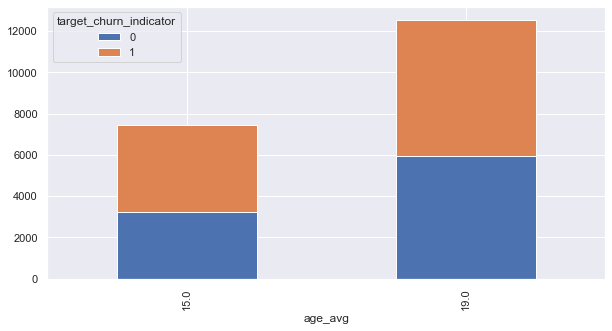

In [26]:
contingencia01 = pd.crosstab(df['age_avg'],df['target_churn_indicator'])
sns.set()
contingencia01.plot(kind='bar', stacked=True,figsize=(10,5))

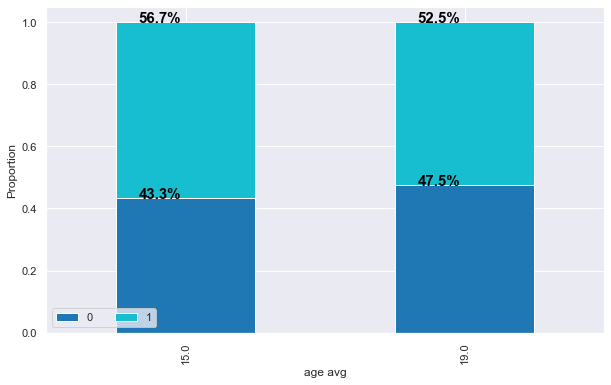

In [27]:
cross_tab = pd.crosstab(index=df['age_avg'], columns=df['target_churn_indicator'])
cross_tab_prop = pd.crosstab(index=df['age_avg'],columns=df['target_churn_indicator'],normalize="index")

cross_tab_prop.plot(kind='bar', stacked=True, colormap='tab10', figsize=(10, 6))
plt.legend(loc="lower left", ncol=2)
plt.xlabel("age avg")
plt.ylabel("Proportion")


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=n - 0.17,
                 y=y_loc,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=15,
                 fontweight="bold")

plt.show()

In [28]:
chi2, p, libertad, conting = chi2_contingency(contingencia01)
print('chi cuadrado: ', chi2)
print('grados de libertad: ', libertad)
print('p: ', p)

chi cuadrado:  32.92371211783764
grados de libertad:  1
p:  9.584704848871665e-09


### Install Time  <a class="anchor" id="InstallTime"></a>

Creo columnas weekday, season, date, hour

In [29]:
df['install_time'] = pd.to_datetime(df['install_time']) #Cambio type

In [30]:
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df['weekday'] = df['install_time'].dt.dayofweek.map(dayOfWeek) #Agrego Weekday

In [31]:
df['hour'] = df['install_time'].dt.hour #Agrego hora

In [32]:
#Todos datos de Argentina
season={1:'Summer', 2:'Summer', 3:'Autumn', 4:'Autumn', 5:'Autumn', 6:'Winter', 7:'Winter',8:'Winter',9:'Spring',10:'Spring',11:'Spring',12:'Summer'}

df['season'] = df['install_time'].dt.month.map(season) #Agrego season

df.head()

,user_id,install_time,platform,country_region,city,gender,event_1,event_2,event_3,event_4,event_5,target_churn_indicator,traveller,age_avg,weekday,hour,season
0,2ba6f357,2018-07-04 16:24:24-03:00,Android,Santa Cruz,Río Gallegos,male,1,2,0,1,1,0,No,15.0,Wednesday,16,Winter
1,3cb936c1,2018-06-30 10:41:29-03:00,Android,Corrientes,Corrientes,male,0,7,0,3,0,1,No,15.0,Saturday,10,Winter
2,17d88bbc,2018-06-30 13:02:30-03:00,Android,Cordoba,Villa Carlos Paz,female,2,1,0,2,2,1,No,19.0,Saturday,13,Winter
3,7baa10b6,2018-07-02 18:08:33-03:00,Android,Buenos Aires,Don Torcuato,female,5,6,0,2,5,0,Yes,15.0,Monday,18,Winter
4,120d379,2018-07-07 01:18:47-03:00,Android,Santiago del Estero,Santiago del Estero,female,8,12,0,2,3,0,No,15.0,Saturday,1,Winter


##### Install time (Date) vs churn
o	2400 instalaciones por dia de promedio.  
o	El primer dia 30/06 en horario UTC, todo churn. Probable error en el dataset o causa de la que no tenemos data.  
o	El resto de los días se mantiene un porcentaje de churn de entre 46,2 y 51,5%.  

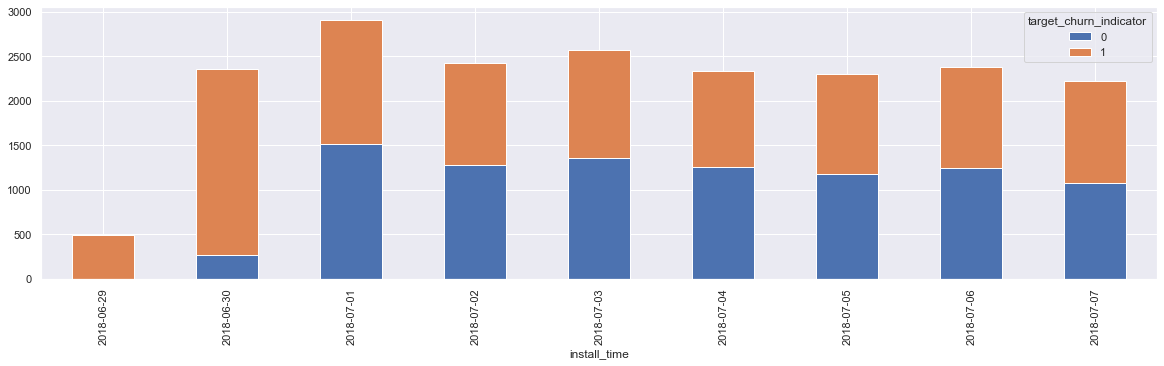

In [33]:
contingencia01 = pd.crosstab(df['install_time'].dt.date,df['target_churn_indicator'])
sns.set()
contingencia01.plot(kind='bar', stacked=True,figsize=(20,5))

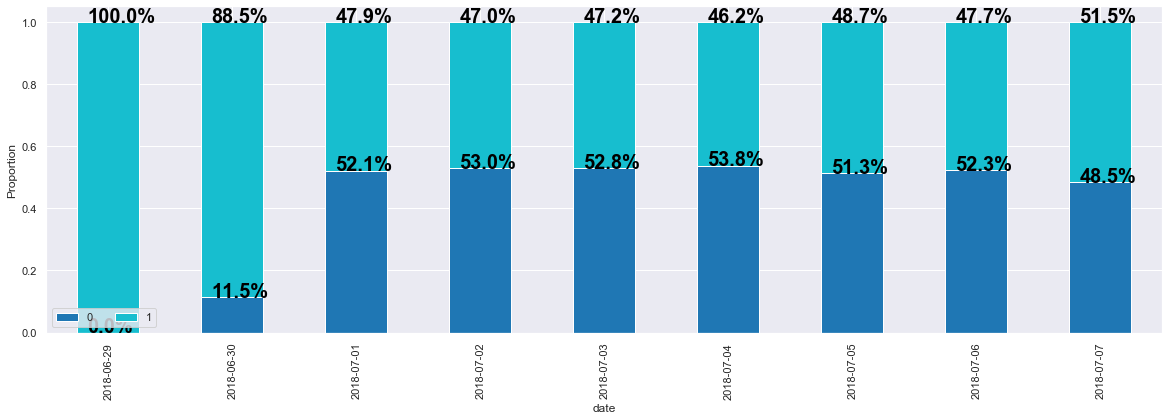

In [34]:
cross_tab = pd.crosstab(index=df['install_time'].dt.date, columns=df['target_churn_indicator'])
cross_tab_prop = pd.crosstab(index=df['install_time'].dt.date,columns=df['target_churn_indicator'],normalize="index")

cross_tab_prop.plot(kind='bar', stacked=True, colormap='tab10', figsize=(20, 6))
plt.legend(loc="lower left", ncol=2)
plt.xlabel("date")
plt.ylabel("Proportion")


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=n - 0.17,
                 y=y_loc,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=20,
                 fontweight="bold")

plt.show()

In [35]:
chi2, p, libertad, conting = chi2_contingency(contingencia01)
print('chi cuadrado: ', chi2)
print('grados de libertad: ', libertad)
print('p: ', p)

chi cuadrado:  1816.5597539230344
grados de libertad:  8
p:  0.0


##### Install time (Hour) vs churn

o	Tendencia como el sentido común lo esperaba: en valor absoluto menos instalaciones en horas de la mañana, creciendo significativamente en la tarde y encontrando su punto máximo entre las 20 y 23 hs, luego, comienza a caer el número hasta el mínimo en la madrugada.  
o	Con respecto al churn, no se ve ningún indicio de que los usuarios que realizan la instalación en determinado momento del día sean más propensos a dejar de jugar.  

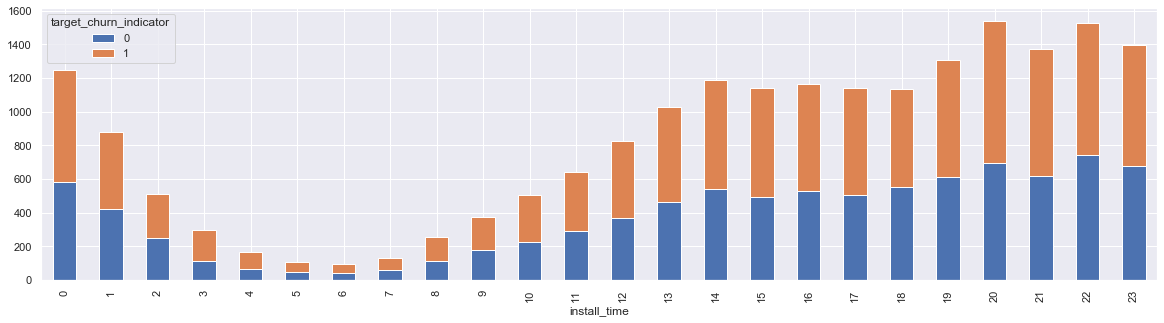

In [36]:
contingencia01 = pd.crosstab(df['install_time'].dt.hour,df['target_churn_indicator'])
sns.set()
contingencia01.plot(kind='bar', stacked=True,figsize=(20,5))

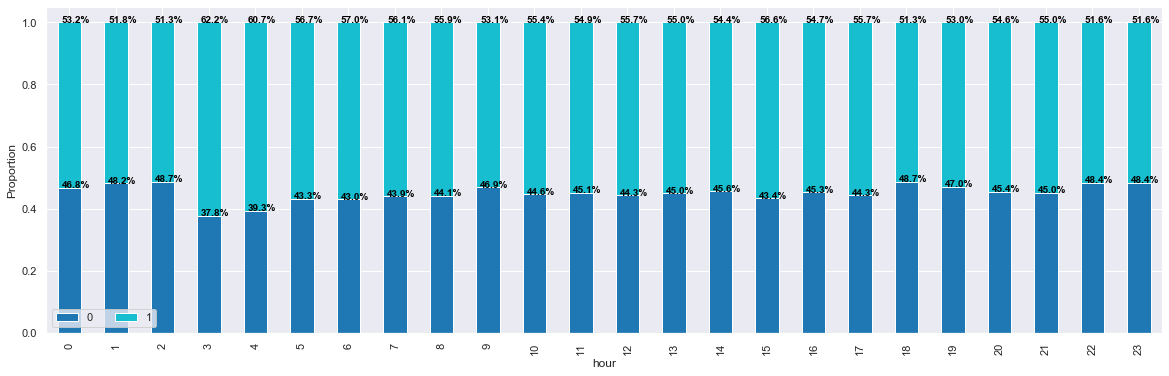

In [37]:
cross_tab = pd.crosstab(index=df['install_time'].dt.hour, columns=df['target_churn_indicator'])
cross_tab_prop = pd.crosstab(index=df['install_time'].dt.hour,columns=df['target_churn_indicator'],normalize="index")

cross_tab_prop.plot(kind='bar', stacked=True, colormap='tab10', figsize=(20, 6))
plt.legend(loc="lower left", ncol=2)
plt.xlabel("hour")
plt.ylabel("Proportion")


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=n - 0.17,
                 y=y_loc,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=10,
                 fontweight="bold")

plt.show()

In [38]:
chi2, p, libertad, conting = chi2_contingency(contingencia01)
print('chi cuadrado: ', chi2)
print('grados de libertad: ', libertad)
print('p: ', p)

chi cuadrado:  34.26507967311156
grados de libertad:  23
p:  0.06142118106534235


##### Install time (weekday) vs churn

o	Al tener solo datos de una semana, será un gráfico muy parecido al de Date. Vemos que el día sábado, parece un día de churn altísimo en promedio, pero es por el efecto de los datos del 30-06, que no sabemos a qué responde sean todos de target churn.

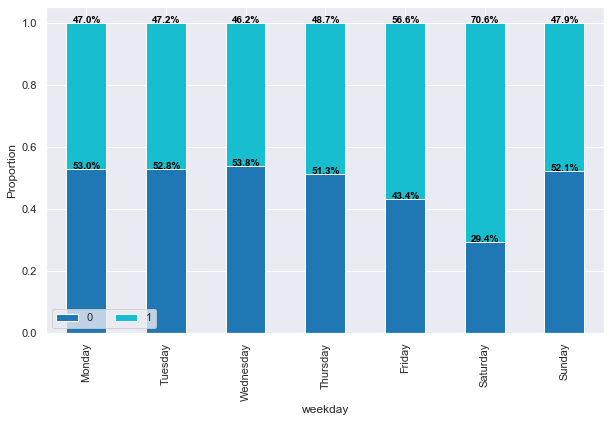

In [39]:
cross_tab = pd.crosstab(index=df['weekday'], columns=df['target_churn_indicator']).reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
cross_tab_prop = pd.crosstab(index=df['weekday'],columns=df['target_churn_indicator'],normalize="index").reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

cross_tab_prop.plot(kind='bar', stacked=True, colormap='tab10', figsize=(10, 6))
plt.legend(loc="lower left", ncol=2)
plt.xlabel("weekday")
plt.ylabel("Proportion")


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=n - 0.17,
                 y=y_loc,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=10,
                 fontweight="bold")

plt.show()

In [40]:
chi2, p, libertad, conting = chi2_contingency(cross_tab)
print('chi cuadrado: ', chi2)
print('grados de libertad: ', libertad)
print('p: ', p)

chi cuadrado:  735.6147198214937
grados de libertad:  6
p:  1.2469973858932302e-155


### Platform  <a class="anchor" id="Platform"></a>

-	Las instalaciones de jugadores de iOS representan solo el 2,39% del total.
-	Si analizamos el comportamiento por plataforma vs el % de churn, vemos que los usuarios de iOS en un 60% siguieron jugando, contra un 45% de los de Android. Sería bueno agrandar la muestra para verificar que los usuarios de Android cometen más churn e indagar en las posibles causas: interfaz del usuario más compleja, necesidad de más soporte, etc.

In [41]:
collections.Counter(df['platform'])

Counter({'Android': 19499, 'iOS': 478})

In [42]:
contingencia01 = pd.crosstab(df['platform'],df['target_churn_indicator'])
contingencia01

target_churn_indicator,0,1
platform,,
Android,8892,10607
iOS,288,190


In [43]:
print( "Porcentaje de iOS: ", round(contingencia01[1:2].sum().sum() / (contingencia01[0:1].sum().sum() + contingencia01[1:2].sum().sum()) * 100,2), "%")

Porcentaje de iOS:  2.39 %


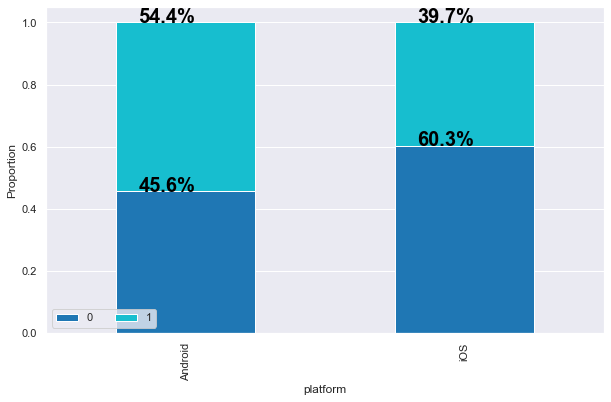

In [44]:
cross_tab = pd.crosstab(index=df['platform'], columns=df['target_churn_indicator'])
cross_tab_prop = pd.crosstab(index=df['platform'],columns=df['target_churn_indicator'],normalize="index")

cross_tab_prop.plot(kind='bar', stacked=True, colormap='tab10', figsize=(10, 6))
plt.legend(loc="lower left", ncol=2)
plt.xlabel("platform")
plt.ylabel("Proportion")


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=n - 0.17,
                 y=y_loc,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=20,
                 fontweight="bold")

plt.show()

In [45]:
chi2, p, libertad, conting = chi2_contingency(contingencia01)
print('chi cuadrado: ', chi2)
print('grados de libertad: ', libertad)
print('p: ', p)

chi cuadrado:  39.723322777541966
grados de libertad:  1
p:  2.926102569217239e-10


### Gender   <a class="anchor" id="Gender"></a>

-	Tenemos 3 posibilidades: hombre, mujer y desconocido, que elegí tomar como “no binario”. Está balanceado entre hombres y mujeres, pero de la tercera categoría hay solo unas poquitas observaciones.  
-	Si analizamos el comportamiento de cada clase con respecto al churn, vemos que pareciera no haber grandes diferencias entre ellas. Churn cercano al 50% como en el promedio del dataset.

In [46]:
collections.Counter(df['gender'])

Counter({'male': 8984, 'female': 10822, 'unknown': 171})

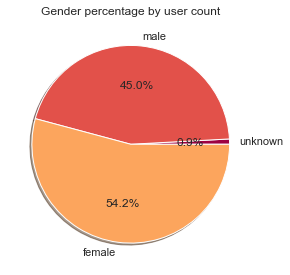

In [47]:
gender = df.groupby('gender').agg('count')
type_labels = gender['user_id'].sort_values().index 
type_counts = gender['user_id'].sort_values()
plt.figure(1, figsize=(50,10)) 
the_grid = GridSpec(2, 2)
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
plt.subplot(the_grid[0, 1], aspect=1, title='Gender percentage by user count')
type_show_ids = plt.pie(type_counts, labels=type_labels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.show()

###### Gender vs churn

In [48]:
contingencia01 = pd.crosstab(df['gender'],df['target_churn_indicator'])
contingencia01

target_churn_indicator,0,1
gender,,
female,5113,5709
male,3976,5008
unknown,91,80


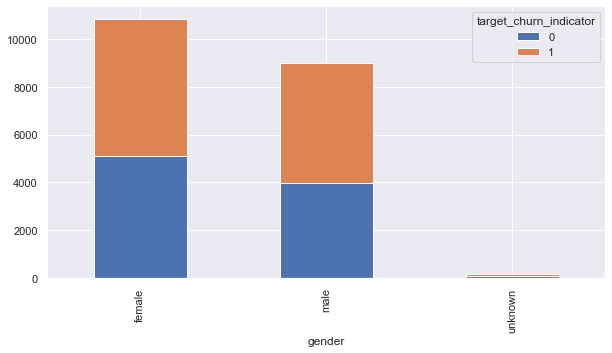

In [49]:
contingencia01 = pd.crosstab(df['gender'],df['target_churn_indicator'])
sns.set()
contingencia01.plot(kind='bar', stacked=True,figsize=(10,5))

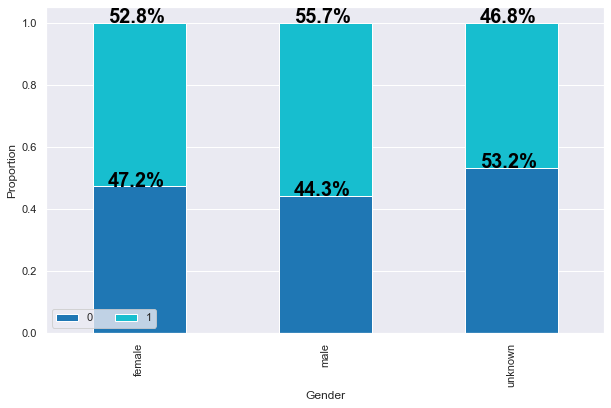

In [50]:
cross_tab = pd.crosstab(index=df['gender'], columns=df['target_churn_indicator'])
cross_tab_prop = pd.crosstab(index=df['gender'],columns=df['target_churn_indicator'],normalize="index")

cross_tab_prop.plot(kind='bar', stacked=True, colormap='tab10', figsize=(10, 6))
plt.legend(loc="lower left", ncol=2)
plt.xlabel("Gender")
plt.ylabel("Proportion")


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=n - 0.17,
                 y=y_loc,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=20,
                 fontweight="bold")

plt.show()

In [51]:
chi2, p, libertad, conting = chi2_contingency(contingencia01)
print('chi cuadrado: ', chi2)
print('grados de libertad: ', libertad)
print('p: ', p)

chi cuadrado:  21.332659024633035
grados de libertad:  2
p:  2.3316961232742686e-05


### Provincia  <a class="anchor" id="Provincia"></a>

Errores en la data, distintos label para la misma provincia, Cordoba, Salta, etc. Se realiza correccion manual y veomos:
-	Representación de todas las provincias del país. Con concentración de observaciones para las provincias con mayor población: CABA, Buenos Aires, Cordoba, etc. Probablemente sea una buena muestra de la realidad aunque no lo cotejé con números oficiales.  
-	Aplicando Pareto, vemos que el 80% de las observaciones se encuentran en Buenos Aires, CABA, Cordoba, Entre Rios, Santa Fe, Tucuman y Mendoza.  
-	Viendo un gráfico stacked 100%, podemos visualizar que algunas provincias tienen comportamiento de churn por encima de la media, como Jujuy y Formosa.  


In [52]:
df['country_region'] = np.where(df['country_region']=='Buenos Aires F.D.','Ciudad Autónoma de Buenos Aires',df['country_region'])
df['country_region'] = np.where(df['country_region']=='Chaco Province','Chaco',df['country_region'])
df['country_region'] = np.where(df['country_region']=='Chubut Province','Chubut',df['country_region'])
df['country_region'] = np.where(df['country_region']=='Cordoba Province','Cordoba',df['country_region'])
df['country_region'] = np.where(df['country_region']=='Entre Ríos Province','Entre Rios',df['country_region'])
df['country_region'] = np.where(df['country_region']=='Neuquén Province','Neuquen',df['country_region'])
df['country_region'] = np.where(df['country_region']=='Río Negro Province','Rio Negro',df['country_region'])
df['country_region'] = np.where(df['country_region']=='Salta Province','Salta',df['country_region'])
df['country_region'] = np.where(df['country_region']=='Santa Fe Province','Santa Fe',df['country_region'])
df['country_region'] = np.where(df['country_region']=='Tucumán Province','Tucuman',df['country_region'])

In [53]:
a,b = 'áéíóúü','aeiouu'  #Quito las tildes
trans = str.maketrans(a,b)

df['country_region'] = df.apply(lambda x: x['country_region'].translate(trans), axis=1)

df.head(3)

,user_id,install_time,platform,country_region,city,gender,event_1,event_2,event_3,event_4,event_5,target_churn_indicator,traveller,age_avg,weekday,hour,season
0,2ba6f357,2018-07-04 16:24:24-03:00,Android,Santa Cruz,Río Gallegos,male,1,2,0,1,1,0,No,15.0,Wednesday,16,Winter
1,3cb936c1,2018-06-30 10:41:29-03:00,Android,Corrientes,Corrientes,male,0,7,0,3,0,1,No,15.0,Saturday,10,Winter
2,17d88bbc,2018-06-30 13:02:30-03:00,Android,Cordoba,Villa Carlos Paz,female,2,1,0,2,2,1,No,19.0,Saturday,13,Winter


###### Provincia vs churn

In [54]:
contingencia01 = pd.crosstab(df['country_region'],df['target_churn_indicator']).sort_values(by=0,ascending=False)
contingencia01

target_churn_indicator,0,1
country_region,,
Buenos Aires,3213,4083
Ciudad Autonoma de Buenos Aires,1540,1571
Cordoba,931,969
Entre Rios,514,638
Santa Fe,414,470
Tucuman,342,441
Salta,317,368
Mendoza,308,377
Chaco,175,217


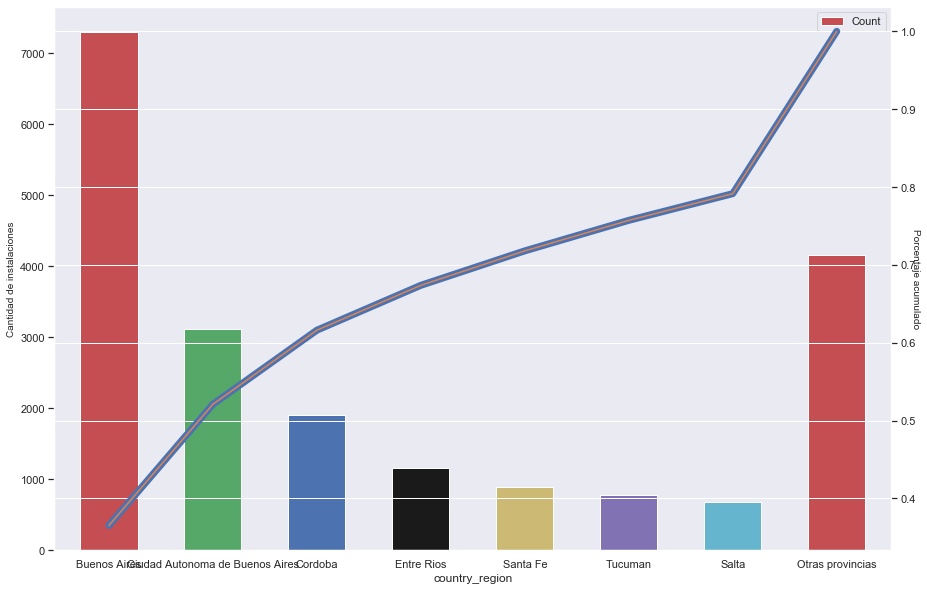

In [55]:
import sidetable
width = .55 # width of a bar

df6 = df.stb.freq(['country_region'], thresh=.8, other_label='Otras provincias')
df6 = df6.set_index('country_region')
ax = df6[['Count']].plot(kind='bar', width = width, color='rgbkymc', figsize=(15,10));
df6['Cumulative Percent'].plot(secondary_y=True, linewidth=7)
 
ax.set_ylabel('Cantidad de instalaciones', fontsize=10);
df6['Cumulative Percent'].plot(ax=ax, secondary_y=True);


plt.xlabel('xlabel', fontsize=10)
plt.ylabel('Porcentaje acumulado', fontsize=10, rotation=-90)


plt.show()

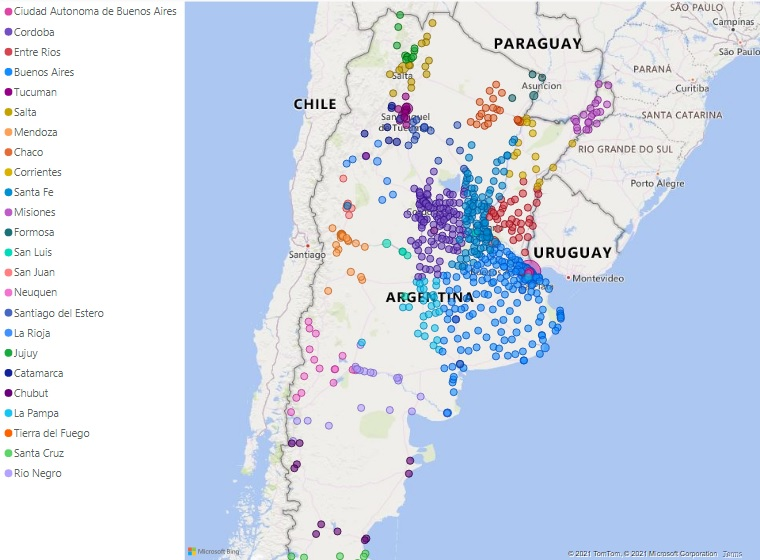

In [56]:
from IPython.display import display, Image
display(Image(filename='data/map.jpg'))

Stacked 100% para entender que porcentaje de churn tenemos en cada provincia

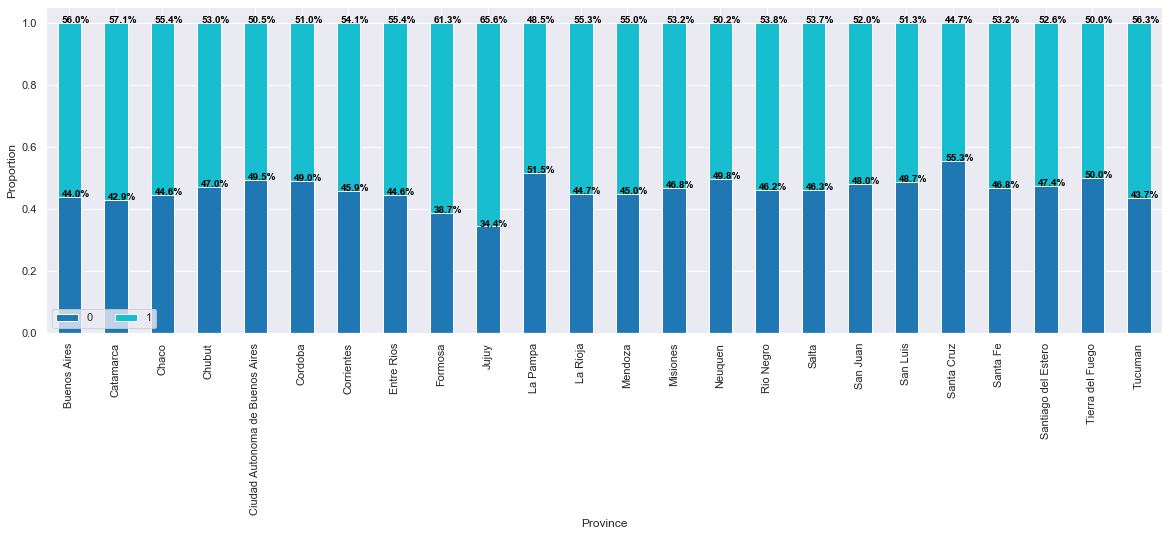

In [57]:
cross_tab = pd.crosstab(index=df['country_region'], columns=df['target_churn_indicator'])
cross_tab_prop = pd.crosstab(index=df['country_region'],columns=df['target_churn_indicator'],normalize="index")

cross_tab_prop.plot(kind='bar', stacked=True, colormap='tab10', figsize=(20, 6))
plt.legend(loc="lower left", ncol=2)
plt.xlabel("Province")
plt.ylabel("Proportion")


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=n - 0.17,
                 y=y_loc,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=10,
                 fontweight="bold")

plt.show()

In [58]:
chi2, p, libertad, conting = chi2_contingency(contingencia01)
print('chi cuadrado: ', chi2)
print('grados de libertad: ', libertad)
print('p: ', p)

chi cuadrado:  61.470885423202496
grados de libertad:  23
p:  2.3350118681738267e-05


### City  <a class="anchor" id="City"></a>

-	Decidí solo hacer algunos chequeos a grandes rasgos de la variable y luego no incluirla, básicamente porque tiene muchos valores únicos, y pocos ejemplares de cada uno de ellos, por lo que podemos llegar a conclusiones erróneas.

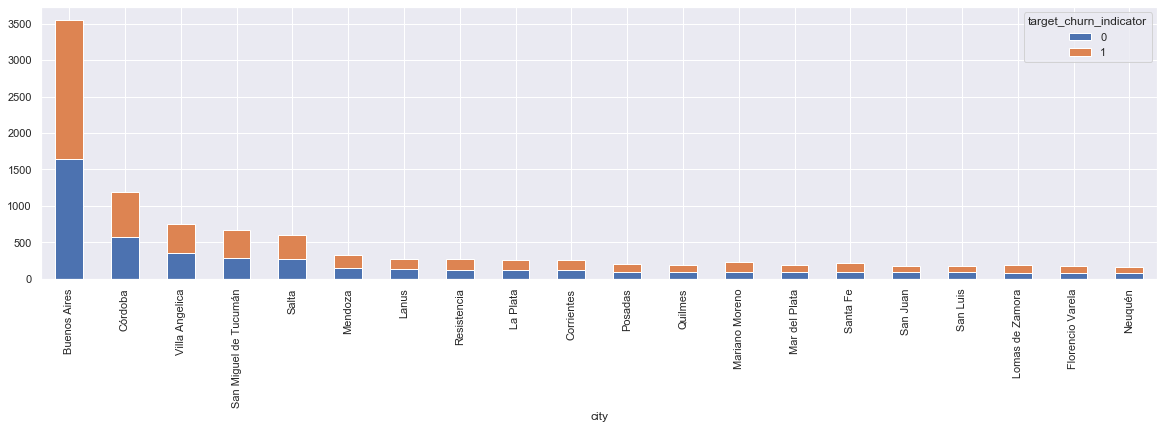

In [59]:
contingencia01 = pd.crosstab(df['city'],df['target_churn_indicator']).sort_values(by=0,ascending=False)[0:20]
sns.set()
contingencia01.plot(kind='bar', stacked=True,figsize=(20,5))

### Traveller:   <a class="anchor" id="Traveller"></a>

-	Esta columna, fue deducida a partir de los datos: usuarios que se encontraban duplicados por tener eventos en diferentes localizaciones geográficas, de ahí que decidí llamarla “traveller”.  
-	El porcentaje de observaciones de usuarios “viajeros”, es el 17%.  
-	Si analizamos el comportamiento de los usuarios en relación al churn, pareciera ser que los usuarios viajeros son más fieles, es decir, cometen menos churn (sólo 30% frente al 58% de los no viajeros).  


In [60]:
cross_tab = pd.crosstab(index=df['traveller'], columns=df['target_churn_indicator'])
cross_tab

target_churn_indicator,0,1
traveller,,
No,7150,9905
Yes,2030,892


In [61]:
print( "Porcentaje de viajeros: ", round(cross_tab[1:2].sum().sum() / cross_tab[0:1].sum().sum() * 100,2), "%")

Porcentaje de viajeros:  17.13 %


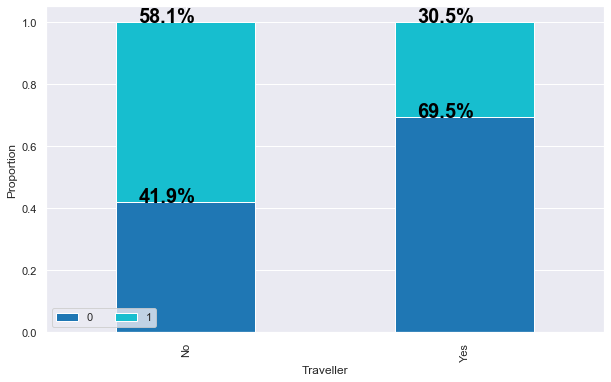

In [62]:
cross_tab = pd.crosstab(index=df['traveller'], columns=df['target_churn_indicator'])
cross_tab_prop = pd.crosstab(index=df['traveller'],columns=df['target_churn_indicator'],normalize="index")

cross_tab_prop.plot(kind='bar', stacked=True, colormap='tab10', figsize=(10, 6))
plt.legend(loc="lower left", ncol=2)
plt.xlabel("Traveller")
plt.ylabel("Proportion")


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=n - 0.17,
                 y=y_loc,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=20,
                 fontweight="bold")

plt.show()

In [63]:
chi2, p, libertad, conting = chi2_contingency(cross_tab)
print('chi cuadrado: ', chi2)
print('grados de libertad: ', libertad)
print('p: ', p)

chi cuadrado:  761.2378100384365
grados de libertad:  1
p:  1.4451771248357677e-167


### Season: sin analisis porque la muestra presenta solo valores Winter
-	Variable no analizada por ser igual para todos los registros. Quizás si hay más datos, puede aportar algún insight que nos haga estudiar más acerca de otras causas de churn, como el clima en su ciudad.

### Events  <a class="anchor" id="Events"></a>

-	Diferentes eventos, de los que no tengo más información más que le hecho de que fueron realizados por ese usuario en cuestión.
-	La distribución de la cantidad de eventos por cada variable es distinta, teniendo rangos y medidas de dispersión distintas.

In [64]:
df_events = df[['event_1', 'event_2','event_3','event_4','event_5']]

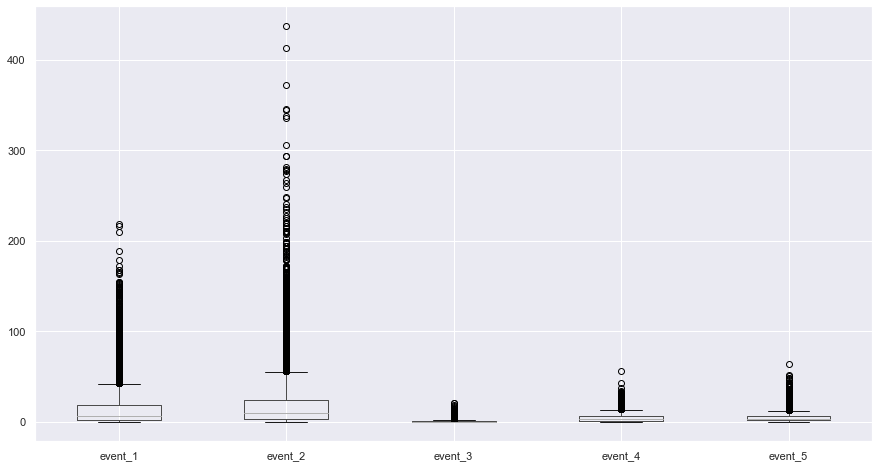

In [65]:
df_events.boxplot(figsize=(15, 8))

-	Tienen similitudes en que parecen distribuciones asimétricas sesgadas hacia la izquierda (cola a la derecha).  
-	Por lo anterior, la moda es menor a la mediana y esta a su vez, menor que la media. Esto se da a causa de que la media, es una medida muy sensible a los outliers, que en el presente caso, están en valores muy grandes de la variable.  


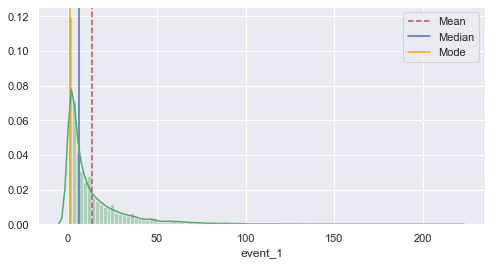

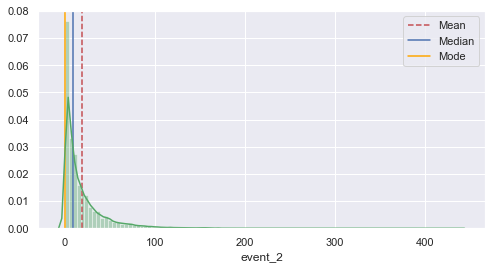

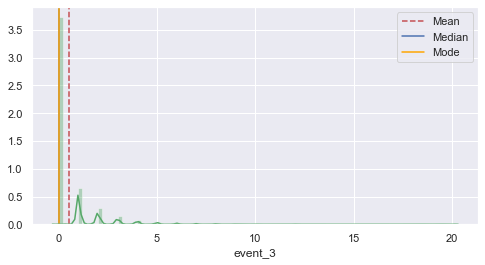

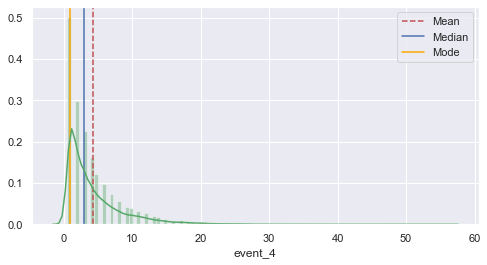

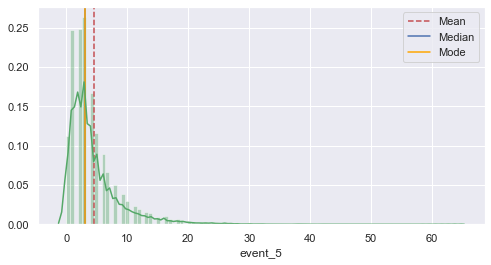

In [66]:
for col in df_events:    
    plt.figure(figsize=(8, 4))
    mean=df_events[col].mean()
    median=df_events[col].median()
    mode=df_events[col].mode()[0]
    plt.axvline(mean, color='r', linestyle='--')
    plt.axvline(median, color='b', linestyle='-')
    plt.axvline(mode, color='orange', linestyle='-')
    plt.legend({'Mean':mean,'Median':median,'Mode':mode})
    sns.distplot(df_events[col], color='g', bins=100, hist_kws={'alpha': 0.4});

-	Observando el pairplot de los events vs churn, podemos ver que hay cierta correlación positiva entre los eventos, y que a medida que los valores de los eventos son más grandes, aparecen más valores 0, es decir, no churn. Pareciera indicar que más eventos, menos churn.

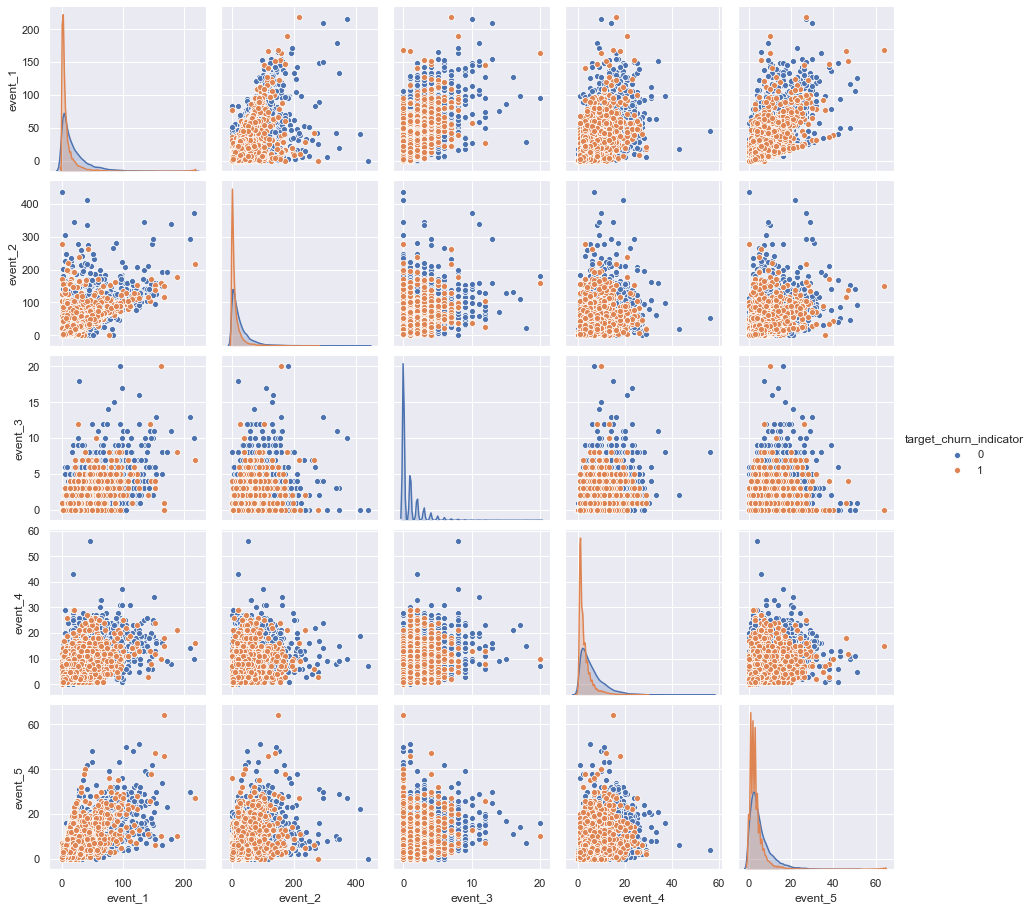

In [67]:
df_events1 = df[['event_1', 'event_2','event_3','event_4','event_5','target_churn_indicator']]
sns.pairplot(df_events1,hue='target_churn_indicator')

-	La matriz de correlacion confirma la primera parte de lo anterior, existe correlación positiva entre los eventos.

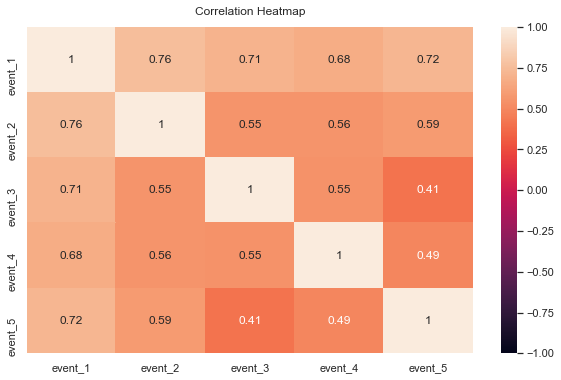

In [68]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df_events.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

-	Los eventos que tienen mayor correlación negativa con churn son el 4 y el 1.

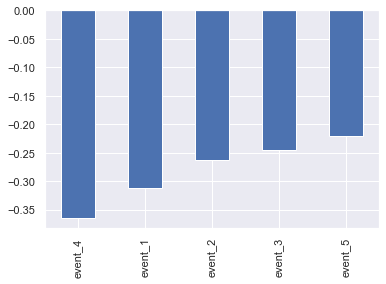

In [69]:
corr_matrix = df[['event_1', 'event_2','event_3','event_4','event_5','target_churn_indicator']].corr()
corr_matrix["target_churn_indicator"][0:5].sort_values(ascending=True).plot(kind='bar')

In [70]:
df_events1 = df[['event_1', 'event_2','event_3','event_4','event_5','target_churn_indicator']]

In [71]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_events1[['event_1', 'event_2','event_3','event_4','event_5']] = scaler.fit_transform(df_events1[['event_1', 'event_2','event_3','event_4','event_5']])

###### Cantidad de eventos promedio por usuario y discriminado por churn y no churn

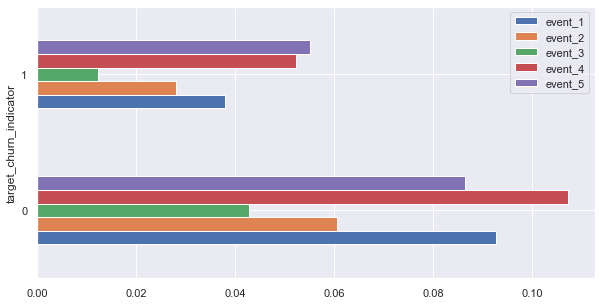

In [72]:
df_events1.groupby(['target_churn_indicator']).mean().plot(kind='barh',figsize=(10,5))

###### En promedio, cuanto más de cada evento tiene un usuario que siguio jugando al otro dia, que uno que realizo churn?

-	Si vemos el gráfico de eventos promedio por usuario y churn, se ve claramente que los eventos 4 y 1 son los que presentan mayor diferencia entre un usuario que siguió jugando al otro día y uno que hizo churn (se confirma que son los más correlacionados negativamente).

In [73]:
aux1 = df_events1.groupby(['target_churn_indicator']).mean()[0:1].reset_index()
aux2 = df_events1.groupby(['target_churn_indicator']).mean()[1:2].reset_index()
dif = aux1 - aux2
dif

,target_churn_indicator,event_1,event_2,event_3,event_4,event_5
0,-1,0.054773,0.032535,0.030653,0.054988,0.031184


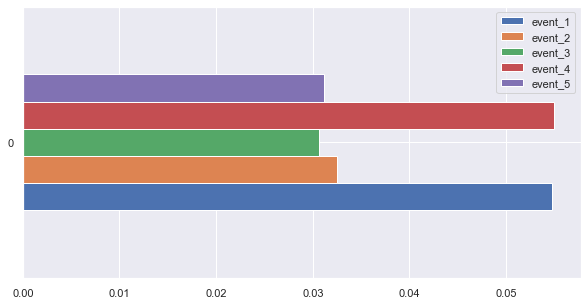

In [74]:
dif = dif[['event_1','event_2','event_3','event_4','event_5']]
dif.plot(kind='barh',figsize=(10,5))

### Merge con clima   <a class="anchor" id="Clima"></a>

Se realizó un dataset simple, bastante manual, que contiene la temperatura máxima y mínima de capital provincial  en los días contenidos en el dataset y además, si llovió o no en ese día puntual.
Se hizo el merge al dataframe principal, para chequear si la temperatura podía estar relacionada con el churn de los usuarios o no.


In [75]:
temp = pd.read_csv('data/temps2.csv',sep=';')
temp.head(3)

,TMAX,TMIN,country_region,Lluvia
0,19.2,5.3,Buenos Aires,Si
1,23.8,6.3,Catamarca,Si
2,28.1,14.9,Chaco,Si


In [76]:
df = pd.merge(df, temp, how="left", on="country_region")
df.head(3)

,user_id,install_time,platform,country_region,city,gender,event_1,event_2,event_3,event_4,event_5,target_churn_indicator,traveller,age_avg,weekday,hour,season,TMAX,TMIN,Lluvia
0,2ba6f357,2018-07-04 16:24:24-03:00,Android,Santa Cruz,Río Gallegos,male,1,2,0,1,1,0,No,15.0,Wednesday,16,Winter,11.2,5.3,No
1,3cb936c1,2018-06-30 10:41:29-03:00,Android,Corrientes,Corrientes,male,0,7,0,3,0,1,No,15.0,Saturday,10,Winter,21.5,7.8,Si
2,17d88bbc,2018-06-30 13:02:30-03:00,Android,Cordoba,Villa Carlos Paz,female,2,1,0,2,2,1,No,19.0,Saturday,13,Winter,24.9,10.6,Si


Posterior al merge, se creo una variable de temperatura promedio, similar al criterio de los rangos de edad.

In [77]:
df['avg_temp'] = (df['TMAX'] + df['TMIN']) / 2
df = df.drop(columns=['TMAX','TMIN'], axis=1)
df.head(3)

,user_id,install_time,platform,country_region,city,gender,event_1,event_2,event_3,event_4,event_5,target_churn_indicator,traveller,age_avg,weekday,hour,season,Lluvia,avg_temp
0,2ba6f357,2018-07-04 16:24:24-03:00,Android,Santa Cruz,Río Gallegos,male,1,2,0,1,1,0,No,15.0,Wednesday,16,Winter,No,8.25
1,3cb936c1,2018-06-30 10:41:29-03:00,Android,Corrientes,Corrientes,male,0,7,0,3,0,1,No,15.0,Saturday,10,Winter,Si,14.65
2,17d88bbc,2018-06-30 13:02:30-03:00,Android,Cordoba,Villa Carlos Paz,female,2,1,0,2,2,1,No,19.0,Saturday,13,Winter,Si,17.75


In [78]:
df.to_csv('df')

### Temperatura
-	Temperatura: pareciera no tener que ver con la decisión o no de churn. Como se ve en el gráfico no hay grandes desviaciones de una curva sobre la otra. (Tiene lógica por lo analizado en Date y Provincia, donde también el comportamiento era similar y son las key de esta nueva feature.)

No pareciera tener relacion con el churn

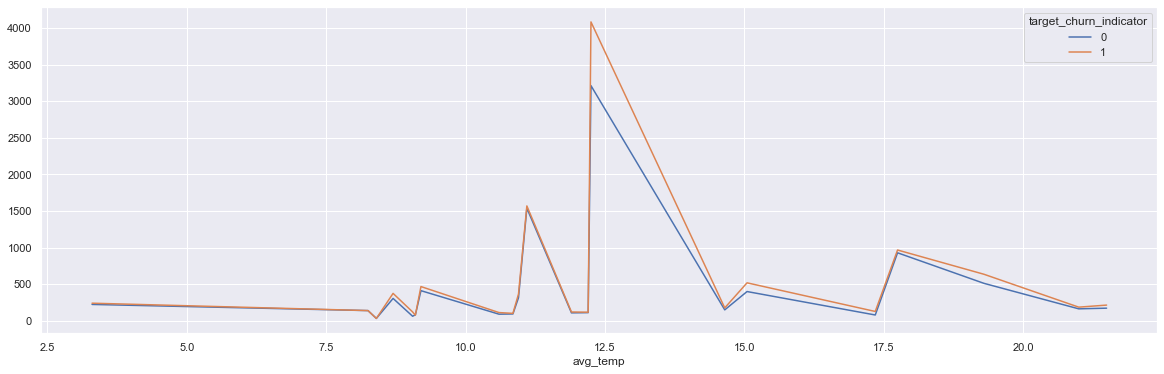

In [79]:
cross_tab = pd.crosstab(index=df['avg_temp'], columns=df['target_churn_indicator']).plot(figsize=(20, 6))

### Lluvia:
-	Lluvia: ídem a temperatura. Sigue los promedios del dataset.

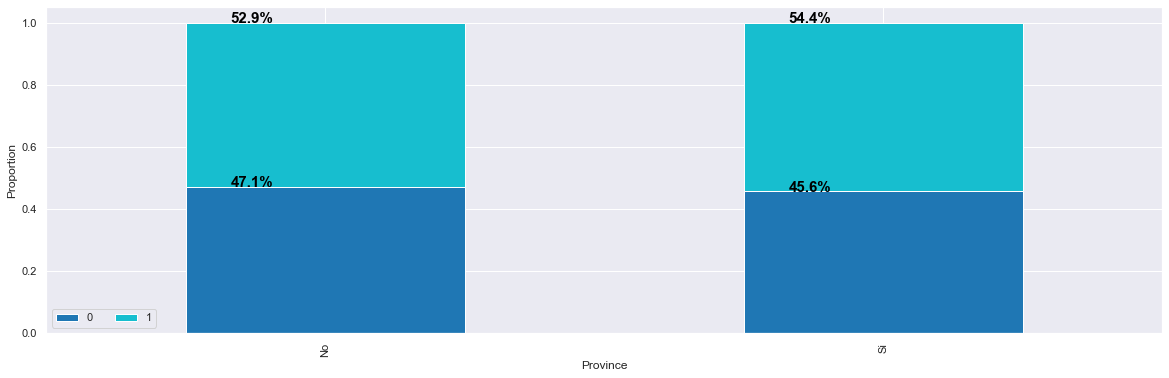

In [80]:
cross_tab = pd.crosstab(index=df['Lluvia'], columns=df['target_churn_indicator'])
cross_tab_prop = pd.crosstab(index=df['Lluvia'],columns=df['target_churn_indicator'],normalize="index")

cross_tab_prop.plot(kind='bar', stacked=True, colormap='tab10', figsize=(20, 6))
plt.legend(loc="lower left", ncol=2)
plt.xlabel("Province")
plt.ylabel("Proportion")


for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                   cross_tab_prop.loc[x].cumsum()):
                
        plt.text(x=n - 0.17,
                 y=y_loc,
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=15,
                 fontweight="bold")

plt.show()

### Modelo de clasificacion. Objetivo: predecir churn.  <a class="anchor" id="Modelo"></a>

Disclaimer: Como no era el objetivo principal del ejercicio, me limité a presentar un modelo básico de clasificación, sin profundizar en temas claves como ingeniería de variables, model tuning, model selection, evaluación de otras métricas, disponibilizar el modelo en producción, etc. La idea era complementar el análisis realizado arriba.

#### Normalizo las variables numericas  <a class="anchor" id="Preprocesamiento"></a>

In [81]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['event_1', 'event_2','event_3','event_4','event_5','age_avg','hour','avg_temp']] = scaler.fit_transform(df[['event_1', 'event_2','event_3','event_4','event_5','age_avg','hour','avg_temp']])
df.head(3)

,user_id,install_time,platform,country_region,city,gender,event_1,event_2,event_3,event_4,event_5,target_churn_indicator,traveller,age_avg,weekday,hour,season,Lluvia,avg_temp
0,2ba6f357,2018-07-04 16:24:24-03:00,Android,Santa Cruz,Río Gallegos,male,0.004587,0.004577,0.0,0.017857,0.015625,0,No,0.0,Wednesday,0.695652,Winter,No,0.271978
1,3cb936c1,2018-06-30 10:41:29-03:00,Android,Corrientes,Corrientes,male,0.000000,0.016018,0.0,0.053571,0.000000,1,No,0.0,Saturday,0.434783,Winter,Si,0.623626
2,17d88bbc,2018-06-30 13:02:30-03:00,Android,Cordoba,Villa Carlos Paz,female,0.009174,0.002288,0.0,0.035714,0.031250,1,No,1.0,Saturday,0.565217,Winter,Si,0.793956


#### Encoding categoricas

In [82]:
df_final = pd.get_dummies(df, columns = ['gender','country_region','traveller','platform','weekday','season','Lluvia'])
df_final.head(3)

,user_id,install_time,city,event_1,event_2,event_3,event_4,event_5,target_churn_indicator,age_avg,...,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,season_Winter,Lluvia_No,Lluvia_Si
0,2ba6f357,2018-07-04 16:24:24-03:00,Río Gallegos,0.004587,0.004577,0.0,0.017857,0.015625,0,0.0,...,0,0,0,0,0,0,1,1,1,0
1,3cb936c1,2018-06-30 10:41:29-03:00,Corrientes,0.000000,0.016018,0.0,0.053571,0.000000,1,0.0,...,0,0,1,0,0,0,0,1,0,1
2,17d88bbc,2018-06-30 13:02:30-03:00,Villa Carlos Paz,0.009174,0.002288,0.0,0.035714,0.031250,1,1.0,...,0,0,1,0,0,0,0,1,0,1


In [83]:
df_final = df_final.drop(columns=['user_id','install_time','city'], axis=1)

In [84]:
df_final.head(3)

,event_1,event_2,event_3,event_4,event_5,target_churn_indicator,age_avg,hour,avg_temp,gender_female,...,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,season_Winter,Lluvia_No,Lluvia_Si
0,0.004587,0.004577,0.0,0.017857,0.015625,0,0.0,0.695652,0.271978,0,...,0,0,0,0,0,0,1,1,1,0
1,0.000000,0.016018,0.0,0.053571,0.000000,1,0.0,0.434783,0.623626,0,...,0,0,1,0,0,0,0,1,0,1
2,0.009174,0.002288,0.0,0.035714,0.031250,1,1.0,0.565217,0.793956,1,...,0,0,1,0,0,0,0,1,0,1


In [85]:
df_final.columns

Index(['event_1', 'event_2', 'event_3', 'event_4', 'event_5',
       'target_churn_indicator', 'age_avg', 'hour', 'avg_temp',
       'gender_female', 'gender_male', 'gender_unknown',
       'country_region_Buenos Aires', 'country_region_Catamarca',
       'country_region_Chaco', 'country_region_Chubut',
       'country_region_Ciudad Autonoma de Buenos Aires',
       'country_region_Cordoba', 'country_region_Corrientes',
       'country_region_Entre Rios', 'country_region_Formosa',
       'country_region_Jujuy', 'country_region_La Pampa',
       'country_region_La Rioja', 'country_region_Mendoza',
       'country_region_Misiones', 'country_region_Neuquen',
       'country_region_Rio Negro', 'country_region_Salta',
       'country_region_San Juan', 'country_region_San Luis',
       'country_region_Santa Cruz', 'country_region_Santa Fe',
       'country_region_Santiago del Estero', 'country_region_Tierra del Fuego',
       'country_region_Tucuman', 'traveller_No', 'traveller_Yes',
       

Train-test split

In [86]:
X=df_final.drop(axis=1,columns='target_churn_indicator')
y=df_final['target_churn_indicator']     

In [87]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
# Librerías para evaluar
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [88]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=123)

###### Modelo:  <a class="anchor" id="Modelo1"></a>
-	Regresión Logística (sin penalidad ni tuning de hiperparametros)

In [89]:
modeloRLog=linear_model.LogisticRegression(penalty='none',fit_intercept=True, random_state=123,max_iter=100000)
modeloRLog.fit(X_train,y_train)

LogisticRegression(max_iter=100000, penalty='none', random_state=123)

##### Evaluacion:  <a class="anchor" id="Evaluacion"></a>
-	Siendo el problema de clasificación bivariada, y teniendo un dataset balanceado, podemos decir que el modelo es bastante mejor que el azar, permitiendo con las características evaluadas, predecir con buena probabilidad si un usuario es un posible churn y tomar acciones preventivas para evitarlo.

In [90]:
y_pred=modeloRLog.predict(X_test)

AC_RLog=round(accuracy_score(y_test, y_pred),3)
F1_RLog=round(f1_score(y_test,y_pred, average='macro'),3)

# Mostrammos:

print("Evaluación modelo de Regresión Logística en el Validation")
print("Accuracy: ", AC_RLog)
print("F1: ", F1_RLog)

Evaluación modelo de Regresión Logística en el Validation
Accuracy:  0.733
F1:  0.725


[Text(21.5, 0.5, 'True Label'),
 Text(0.5, 21.5, 'Predicted Label'),
 Text(0.5, 1, 'Heatmap')]

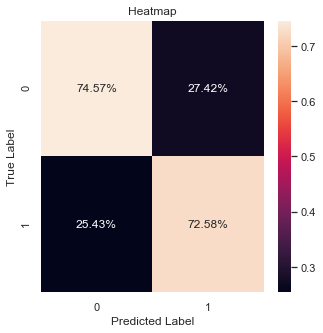

In [91]:
cm_labels = np.unique(y_test)

cm_array = confusion_matrix(y_test,y_pred)
cv_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
plt.subplots(figsize=(5,5))
ax = sns.heatmap(cv_array_df/np.sum(cv_array_df), fmt='.2%', annot=True, xticklabels=True, yticklabels=True)
ax.set(title="Heatmap",
      xlabel="Predicted Label",
      ylabel="True Label")

### Explicacion del modelo con Shapley  <a class="anchor" id="Shap"></a>
A través de Shapley podemos ver la importancia que le asigna el modelo a cada feature y, como era de esperar por el análisis previo, vemos que las variables más importantes son:
-	event_4: más eventos, menos churn.
-	weekend_Saturday: si es sábado, hay más probabilidades de churn  (debido al 30-06 con todos churn).
-	event_1: más eventos, menos churn.
-	Traveller: si es viajero, menos posibilidades de churn.
-	Events 2 3 5: mas eventos, menos churn.
-	El resto de las variables, parecen que aportan poca información al problema.


In [92]:
from shapash.explainer.smart_explainer import SmartExplainer
xpl = SmartExplainer()
df_y_pred = pd.DataFrame(y_pred, columns=['pred'],index= X_test.index)
xpl.compile(x=X_test, model=modeloRLog, y_pred= df_y_pred)
xpl.run_app(port=8051)

Backend: Shap LinearExplainer
Dash is running on http://0.0.0.0:8051/



INFO:root:Your Shapash application run on http://DESKTOP-QHGSP2P:8051/
INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8051/

INFO:root:Use the method .kill() to down your app.


<CustomThread(Thread-7, started 8784)>

 * Serving Flask app "shapash.webapp.smart_app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


In [93]:
import shap
explainer = shap.LinearExplainer(modeloRLog,masker=shap.maskers.Impute(data=X_train),
                           feature_names=X_train.columns, algorithm="linear")
shap_values = explainer(X_test)

INFO:werkzeug: * Running on http://0.0.0.0:8051/ (Press CTRL+C to quit)


Podemos ver que los travellers tienden a no hacer churn y los sabados son un dia de mucho churn. Quizas el juego funciona mas lento por sobrecarga de los servidores? Falta de mantenimiento los fines de semana?

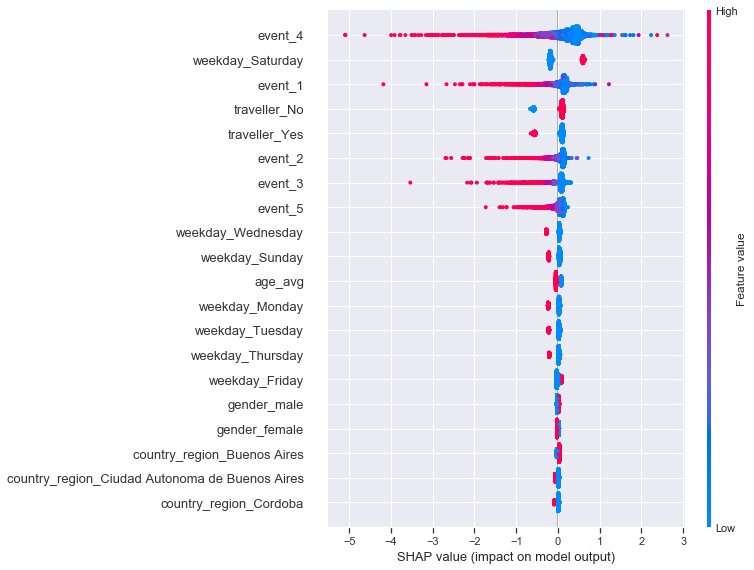

In [94]:
shap.summary_plot(shap_values, X_test)